# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os
import dotenv
from pathlib import Path

env_file = "../.env"

if os.path.exists(env_file):
    dotenv.load_dotenv(env_file, verbose=True)
    print("Loaded environment variables from .env file.")

cwd = os.getcwd()
# for some reason appending to PATH you need it to be string
sys.path.append(str(Path(cwd).parent / "src"))
hf_access_token = os.getenv("HUGGINGFACE_API_KEY")

# from research_tools.gpu import get_gpus_available
# os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(i) for i in get_gpus_available()])

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Loaded environment variables from .env file.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
import numpy as np
import pickle
import itertools
import math

from networks_edm import SongUNet

import copy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device == torch.device("cuda")

In [ ]:
import random

# b. MNIST Data Loader

In [4]:
tensor_transform = transforms.Compose([transforms.ToTensor()])

batch_size = 256
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=tensor_transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=tensor_transform
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

# **$v$-EDM**

In [ ]:
class EDMVel(torch.nn.Module):
    def __init__(self, model=None):
        super().__init__()
        self.device = device
        self.model = model.to(self.device)
        self.ema = copy.deepcopy(self.model).eval().requires_grad_(False)
        ## parameters
        self.sigma_min = 0.002
        self.sigma_max = 80.0
        self.rho = 7.0
        self.sigma_data = 0.5
        self.P_mean = -1.2
        self.P_std = 1.2
        self.sigma_data = 0.5
        self.ema_rampup_ratio = 0.05
        self.ema_halflife_kimg = 500
        self.drop_prob = 0.1

    def forward(
        self,
        x_,
        sigma_,
        class_labels=None,
        augment_labels=None,
        force_fp32=False,
        use_ema=False,
        **model_kwargs
    ):
        # sigma_[sigma_>0.988] = 0.988
        # Assume sigma_ is in [0.001, 80/81].
        # assert (sigma_ >= 0.001).all() and (sigma_ <= 80/81).all()
        # Rescale x and sigma.
        x = x_ / (1 - sigma_).view(-1, 1, 1, 1)
        sigma = sigma_ / (1 - sigma_)

        # Compute posterior mean D_x
        x = x.to(torch.float32)
        # augment_labels = torch.zeros([x.shape[0], self.augment_dim], device = x.device)
        sigma = sigma.to(torch.float32).reshape(-1, 1, 1, 1)
        # class_labels = None if self.label_dim == 0 else torch.zeros([1, self.label_dim], device=x.device) if class_labels is None else class_labels.to(torch.float32).reshape(-1, self.label_dim)
        dtype = torch.float32

        c_skip = self.sigma_data**2 / (sigma**2 + self.sigma_data**2)
        c_out = sigma * self.sigma_data / (sigma**2 + self.sigma_data**2).sqrt()
        c_in = 1 / (self.sigma_data**2 + sigma**2).sqrt()
        c_noise = sigma.log() / 4

        if use_ema:
            F_x = self.ema(
                (c_in * x).to(dtype),
                c_noise.flatten(),
                class_labels=class_labels,
                **model_kwargs
            )
        else:
            F_x = self.model(
                (c_in * x).to(dtype),
                c_noise.flatten(),
                class_labels=class_labels,
                **model_kwargs
            )
        assert F_x.dtype == dtype
        D_x = c_skip * x + c_out * F_x.to(torch.float32)

        # Compute v_t
        v_t = (x_ - D_x) / sigma_.view(-1, 1, 1, 1)
        return v_t

    def update_ema(self, step):
        ema_halflife_nimg = self.ema_halflife_kimg * 1000
        if self.ema_rampup_ratio is not None:
            ema_halflife_nimg = min(
                ema_halflife_nimg, step * batch_size * self.ema_rampup_ratio
            )
        ema_beta = 0.5 ** (batch_size / max(ema_halflife_nimg, 1e-8))
        for p_ema, p_net in zip(self.ema.parameters(), self.model.parameters()):
            p_ema.copy_(p_net.detach().lerp(p_ema, ema_beta))

    def round_sigma(self, sigma):
        return torch.as_tensor(sigma)

In [ ]:
@torch.no_grad()
def v_edm_sampler(
    v_edm,
    latents,
    class_labels=None,
    num_steps=18,
    guide_w=0.0,
    use_ema=True,
    cfg=True,
    drop_prob=0.0,
):
    time_schedule = [(i / num_steps) for i in reversed(range(1, num_steps + 1))] + [0]
    time_schedule[0] = 1 - 1e-5
    cnt = 0
    print(f"Time schedule: {time_schedule}")

    if class_labels is not None:
        class_labels = (
            nn.functional.one_hot(class_labels, num_classes=10)
            .type(torch.float32)
            .to(latents.device)
        )
        mask = torch.bernoulli(torch.ones_like(class_labels) * (1 - drop_prob))
        class_labels = class_labels * mask
        if cfg:
            class_labels = torch.cat([class_labels, torch.zeros_like(class_labels)])
    # Main sampling loop.
    x_next = latents.to(torch.float64).to(device) * time_schedule[0]

    rand_x = random.choice([10 + i for i in range(8)])
    rand_y = random.choice([10 + i for i in range(8)])

    random_trajs = [
        [x_next[i, 0, rand_x, rand_y].detach().cpu().item()]
        for i in range(latents.shape[0])
    ]
    middle = None
    for i in tqdm(range(len(time_schedule[:-1]))):
        t = (
            torch.ones((latents.shape[0] * (2 if cfg else 1),), device=device)
            * time_schedule[i]
        )
        t_next = (
            torch.ones((latents.shape[0] * (2 if cfg else 1),), device=x_next.device)
            * time_schedule[i + 1]
        )
        dt = t_next[0] - t[0]
        if cfg:
            x_hat = x_next.repeat(2, 1, 1, 1)
        else:
            x_hat = x_next

        vt = v_edm(x_hat, t, class_labels, use_ema=use_ema).to(torch.float64)
        x_next = x_hat + vt * dt

        # cfg guide
        if cfg:
            x_next_cond, x_next_uncond = x_next.chunk(2)
            x_next = (1 + guide_w) * x_next_cond - guide_w * x_next_uncond
        if i == (num_steps // 2):
            middle = x_next.clone().detach()

    return x_next, middle, class_labels

# c. SongUNet



In [ ]:
def create_model():
    unet = SongUNet(
        in_channels=1,
        out_channels=1,
        num_blocks=2,
        attn_resolutions=[0],
        model_channels=32,
        channel_mult=[1, 2, 2],
        dropout=0.13,
        img_resolution=28,
        label_dim=10,
        label_dropout=0.1,
        embedding_type="positional",
        encoder_type="standard",
        decoder_type="standard",
        augment_dim=0,
        channel_mult_noise=1,
        resample_filter=[1, 1],
    )
    pytorch_total_grad_params = sum(
        p.numel() for p in unet.parameters() if p.requires_grad
    )
    print(
        f"total number of trainable parameters in the Score Model: {pytorch_total_grad_params}"
    )
    pytorch_total_params = sum(p.numel() for p in unet.parameters())
    print(f"total number of parameters in the Score Model: {pytorch_total_params}")
    return unet

# c. Training Function

In [ ]:
def train_main_loop(
    edm, optim, dataloader, lr, ws_test, n_epoch, batch_size, no_gen=False
):
    cnt = 0
    for ep in range(n_epoch):
        print(f"epoch {ep}")
        edm.model.train()

        # linear lrate decay
        # optim.param_groups[0]['lr'] = lr*(1-ep/n_epoch)

        pbar = tqdm(dataloader)
        loss_ema = None
        # train

        for x, c in pbar:
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            # print(x.shape)
            # print(c.shape)
            loss = edm.train_step(x, c)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()
            edm.update_ema(cnt)
            cnt += 1

        # eval
        if ep % 2 == 0:
            edm.model.eval()
            with torch.no_grad():
                n_sample = 20
                for w_i, w in enumerate(ws_test):
                    x_T = torch.randn([n_sample, 1, 28, 28], device=device)
                    c = torch.arange(0, 10).to(device)
                    x_gen = (
                        edm_sampler(edm, x_T, class_labels=c, guide_w=w).detach().cpu()
                    )

                    x_gen = (x_gen / 2 + 0.5).clamp(0, 1)

                    fig, ax = plt.subplots(5, 4, figsize=(6, 6))
                    for i, j in itertools.product(range(5), range(4)):
                        ax[i, j].get_xaxis().set_visible(False)
                        ax[i, j].get_yaxis().set_visible(False)

                    for k in range(n_sample):
                        i = k // 4
                        j = k % 4
                        ax[i, j].cla()
                        ax[i, j].imshow(
                            x_gen[k, :].data.cpu().numpy().reshape(28, 28), cmap="Greys"
                        )
                    plt.show()
            edm.model.train()
        if ep == n_epoch - 1:
            plt.savefig("final_generated_samples.png", bbox_inches="tight")

# e. Training


In [ ]:
# # hardcoding these here
# n_epoch = 20
# n_T = 400
# n_feat = 128
# lr = 1e-4
# ws_test = [0.0, 0.5, 2.0]

# unet = create_model().to(device)
# edm = EDM(model=unet)
# edm.model.to(device)

# tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

# optim = torch.optim.Adam(edm.model.parameters(), lr=lr)
# train_main_loop(edm, optim, train_loader, lr, ws_test, n_epoch, batch_size)

# f. Sampling Test on Checkpoint

In [10]:
unet = create_model().to(device)
unet.load_state_dict(torch.load("edm_model_checkpoint.pth"))
v_edm = EDMVel(model=unet)
v_edm.model.to(device)

total number of trainable parameters in the Score Model: 1703041
total number of parameters in the Score Model: 1703041


/tmp/ipykernel_2835590/2852889410.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load('edm_model_checkpoint.pth'))


SongUNet(
  (map_noise): PositionalEmbedding()
  (map_label): Linear()
  (map_layer0): Linear()
  (map_layer1): Linear()
  (enc): ModuleDict(
    (28x28_conv): Conv2d()
    (28x28_block0): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
    )
    (28x28_block1): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
    )
    (14x14_down): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
      (skip): Conv2d()
    )
    (14x14_block0): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
      (skip): Conv2d()
    )
    (14x14_block1): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm

Time schedule: [0.99999, 0.9444444444444444, 0.8888888888888888, 0.8333333333333334, 0.7777777777777778, 0.7222222222222222, 0.6666666666666666, 0.6111111111111112, 0.5555555555555556, 0.5, 0.4444444444444444, 0.3888888888888889, 0.3333333333333333, 0.2777777777777778, 0.2222222222222222, 0.16666666666666666, 0.1111111111111111, 0.05555555555555555, 0]


  0%|          | 0/18 [00:00<?, ?it/s]

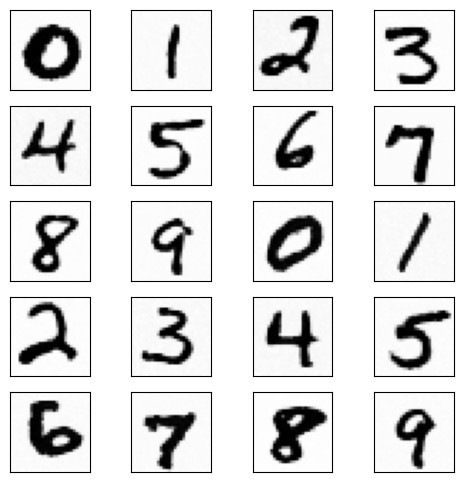

In [11]:
v_edm.model.eval()
with torch.no_grad():
    n_sample = 20
    x_T = torch.randn([n_sample, 1, 28, 28], device=device)
    c = torch.arange(0, 10).repeat(2).to(device)
    x_gen, mid, c = v_edm_sampler(v_edm, x_T, class_labels=c, num_steps=18, guide_w=4.5)

    x_gen = (x_gen / 2 + 0.5).clamp(0, 1)

    fig, ax = plt.subplots(5, 4, figsize=(6, 6))
    for i, j in itertools.product(range(5), range(4)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(n_sample):
        i = k // 4
        j = k % 4
        ax[i, j].cla()
        ax[i, j].imshow(x_gen[k, :].data.cpu().numpy().reshape(28, 28), cmap="Greys")
    plt.show()

# g. Generate Reflow Triples

In [12]:
import json
from torch.utils.data import Dataset, DataLoader
import os

In [13]:
class LatentImageDataset(Dataset):
    def __init__(self, data_dir, metadata_path):
        """
        Custom Dataset for latent-image pairs.

        Args:
            data_dir: Directory containing the .pt files
            metadata_path: Path to the metadata JSON file
        """
        self.data_dir = data_dir
        with open(metadata_path, "r") as f:
            self.metadata = json.load(f)
        self.num_samples = self.metadata["num_samples"] - (
            self.metadata["num_samples"] % 512
        )

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        chunk_idx = idx // self.metadata["chunk_size"]
        local_idx = idx % self.metadata["chunk_size"]

        chunk_path = os.path.join(self.data_dir, f"chunk_{chunk_idx}.pt")
        chunk_data = torch.load(chunk_path)

        return {
            "latent": chunk_data["latents"][local_idx],
            "image": chunk_data["images"][local_idx],
            "mid": chunk_data["mids"][local_idx],
            "class_label": chunk_data["labels"][local_idx],
        }

In [14]:
def generate_and_save_dataset(
    edm,
    num_samples,
    chunk_size=1024,
    sampling_batch_size=256,
    num_steps=18,
    image_size=28,
    output_dir="latent_image_dataset",
    device="cuda",
):
    """
    Generate and save a large dataset of latent-image pairs in PyTorch format.

    Args:
        edm: The EDM model
        num_samples: Total number of samples to generate
        chunk_size: Number of samples per saved file
        sampling_batch_size: Batch size for generation
        num_steps: Number of sampling steps
        image_size: Size of the generated images
        output_dir: Directory to save the dataset
        device: Device to run the generation on
    """
    os.makedirs(output_dir, exist_ok=True)

    # Calculate number of chunks and batches
    num_chunks = (num_samples + chunk_size - 1) // chunk_size

    # Metadata to save
    metadata = {
        "num_samples": num_samples,
        "chunk_size": chunk_size,
        "image_size": image_size,
        "num_steps": num_steps,
        "num_chunks": num_chunks,
        "mid_step": 9,
    }

    # Save metadata
    with open(os.path.join(output_dir, "metadata.json"), "w") as f:
        json.dump(metadata, f)

    edm.model.eval()
    current_sample = 0

    with torch.no_grad():
        for chunk_idx in range(num_chunks):
            chunk_samples = min(chunk_size, num_samples - current_sample)
            chunk_batches = (
                chunk_samples + sampling_batch_size - 1
            ) // sampling_batch_size

            # Initialize storage for this chunk
            chunk_latents = []
            chunk_mids = []
            chunk_images = []
            chunk_labels = []

            # Generate batches for this chunk
            for batch_idx in tqdm(
                range(chunk_batches),
                desc=f"Generating chunk {chunk_idx + 1}/{num_chunks}",
            ):

                current_batch_size = min(
                    sampling_batch_size, chunk_samples - batch_idx * sampling_batch_size
                )

                # Generate latents
                x_T = torch.randn(
                    [current_batch_size, 1, image_size, image_size], device=device
                )

                # Generate class labels (cycling through 0-9)
                c = torch.arange(0, 10, device=device).repeat(
                    current_batch_size // 10 + 1
                )[:current_batch_size]

                # Generate images
                x_gen, mid, labs = v_edm_sampler(
                    v_edm,
                    x_T,
                    class_labels=c,
                    num_steps=num_steps,
                    cfg=False,
                    drop_prob=0.1,
                )
                x_gen = (x_gen / 2 + 0.5).clamp(0, 1)

                c = labs

                # Store in lists
                chunk_latents.append(x_T.cpu())
                chunk_images.append(x_gen.cpu())
                chunk_mids.append(mid.cpu())
                chunk_labels.append(c.cpu())

            # Concatenate and save chunk
            chunk_data = {
                "latents": torch.cat(chunk_latents),
                "images": torch.cat(chunk_images),
                "mids": torch.cat(chunk_mids),
                "labels": torch.cat(chunk_labels),
            }

            torch.save(chunk_data, os.path.join(output_dir, f"chunk_{chunk_idx}.pt"))

            current_sample += chunk_samples

    print(f"Dataset saved to {output_dir}")
    total_size = sum(
        os.path.getsize(os.path.join(output_dir, f)) for f in os.listdir(output_dir)
    )
    print(f"Total size: {total_size / (1024*1024*1024):.2f} GB")

# g. Training Reflow

In [15]:
def train_reflow_loop(
    v_edm,
    optim,
    dataloader,
    lr,
    ws_test,
    n_epoch,
    batch_size,
    no_gen=False,
    ref_start=1 - 1e-5,
    ref_end=0,
):
    cnt = 0
    for ep in range(n_epoch):
        print(f"epoch {ep}")
        v_edm.train()

        # linear lrate decay
        # optim.param_groups[0]['lr'] = lr*(1-ep/n_epoch)

        pbar = tqdm(dataloader)
        loss_ema = None
        # train

        for item in pbar:
            c = item["class_label"].to(device)

            if ref_end < 0.2:
                right = item["image"].to(device)
            else:
                right = item["mid"].to(device)
            if ref_start > 0.8:
                left = item["latent"].to(device)
            else:
                left = item["mid"].to(device)

            optim.zero_grad()
            t = ref_start + (ref_end - ref_start) * torch.rand(
                (batch_size,), device=device
            )
            # print(f't shape: {t.shape}')
            # print(f'left shape: {left.shape}')
            # print(f'right shape: {right.shape}')
            xt = (
                (t - ref_end).view(batch_size, -1, 1, 1) * left
                + (ref_start - t).view(-1, 1, 1, 1) * right
            ) / (ref_start - ref_end)
            v_gt = (left - right) / (ref_start - ref_end)
            out = v_edm(xt, t, c)
            loss = (out - v_gt).square().mean()
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()
            v_edm.update_ema(cnt)
            cnt += 1

        # eval
        if ep % 2 == 0:
            with torch.no_grad():
                n_sample = 20
                x_T = torch.randn([n_sample, 1, 28, 28], device=device)
                c = torch.arange(0, 10).repeat(2).to(device)
                x_gen, _, _ = v_edm_sampler(
                    v_edm,
                    x_T,
                    class_labels=c,
                    num_steps=18,
                    guide_w=4.5,
                    cfg=True,
                    drop_prob=0.0,
                )

                x_gen = (x_gen / 2 + 0.5).clamp(0, 1)

                fig, ax = plt.subplots(5, 4, figsize=(6, 6))
                for i, j in itertools.product(range(5), range(4)):
                    ax[i, j].get_xaxis().set_visible(False)
                    ax[i, j].get_yaxis().set_visible(False)

                for k in range(n_sample):
                    i = k // 4
                    j = k % 4
                    ax[i, j].cla()
                    ax[i, j].imshow(
                        x_gen[k, :].data.cpu().numpy().reshape(28, 28), cmap="Greys"
                    )
                plt.show()
        if ep == n_epoch - 1:
            plt.savefig("final_generated_samples.png", bbox_inches="tight")

In [16]:
reflow_set = dataset = LatentImageDataset(
    data_dir="latent_image_dataset",
    metadata_path="latent_image_dataset/metadata.json",
)

reflow_loader = DataLoader(
    reflow_set,
    batch_size=512,
    shuffle=True,
)

total number of trainable parameters in the Score Model: 1703041
total number of parameters in the Score Model: 1703041
epoch 0


/tmp/ipykernel_2835590/2549238767.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load('edm_model_checkpoint.pth'))


  0%|          | 0/195 [00:00<?, ?it/s]

/tmp/ipykernel_2835590/2500251761.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chunk_data = torch.load(chunk_path)


Time schedule: [0.99999, 0.9444444444444444, 0.8888888888888888, 0.8333333333333334, 0.7777777777777778, 0.7222222222222222, 0.6666666666666666, 0.6111111111111112, 0.5555555555555556, 0.5, 0.4444444444444444, 0.3888888888888889, 0.3333333333333333, 0.2777777777777778, 0.2222222222222222, 0.16666666666666666, 0.1111111111111111, 0.05555555555555555, 0]


  0%|          | 0/18 [00:00<?, ?it/s]

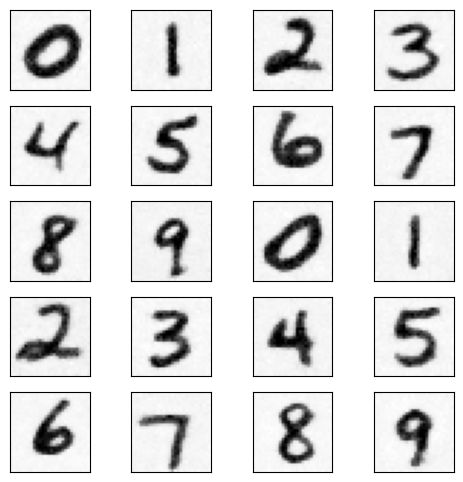

epoch 1


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 2


  0%|          | 0/195 [00:00<?, ?it/s]

Time schedule: [0.99999, 0.9444444444444444, 0.8888888888888888, 0.8333333333333334, 0.7777777777777778, 0.7222222222222222, 0.6666666666666666, 0.6111111111111112, 0.5555555555555556, 0.5, 0.4444444444444444, 0.3888888888888889, 0.3333333333333333, 0.2777777777777778, 0.2222222222222222, 0.16666666666666666, 0.1111111111111111, 0.05555555555555555, 0]


  0%|          | 0/18 [00:00<?, ?it/s]

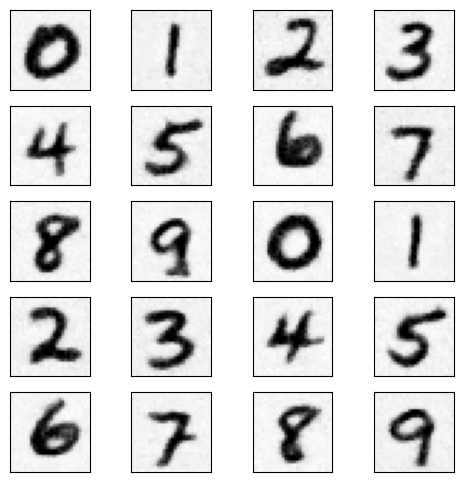

epoch 3


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 4


  0%|          | 0/195 [00:00<?, ?it/s]

Time schedule: [0.99999, 0.9444444444444444, 0.8888888888888888, 0.8333333333333334, 0.7777777777777778, 0.7222222222222222, 0.6666666666666666, 0.6111111111111112, 0.5555555555555556, 0.5, 0.4444444444444444, 0.3888888888888889, 0.3333333333333333, 0.2777777777777778, 0.2222222222222222, 0.16666666666666666, 0.1111111111111111, 0.05555555555555555, 0]


  0%|          | 0/18 [00:00<?, ?it/s]

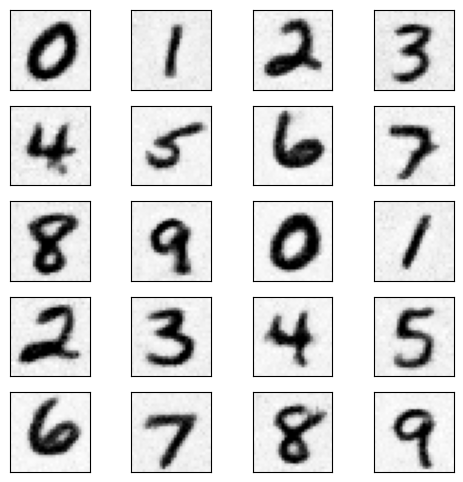

epoch 5


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 6


  0%|          | 0/195 [00:00<?, ?it/s]

Time schedule: [0.99999, 0.9444444444444444, 0.8888888888888888, 0.8333333333333334, 0.7777777777777778, 0.7222222222222222, 0.6666666666666666, 0.6111111111111112, 0.5555555555555556, 0.5, 0.4444444444444444, 0.3888888888888889, 0.3333333333333333, 0.2777777777777778, 0.2222222222222222, 0.16666666666666666, 0.1111111111111111, 0.05555555555555555, 0]


  0%|          | 0/18 [00:00<?, ?it/s]

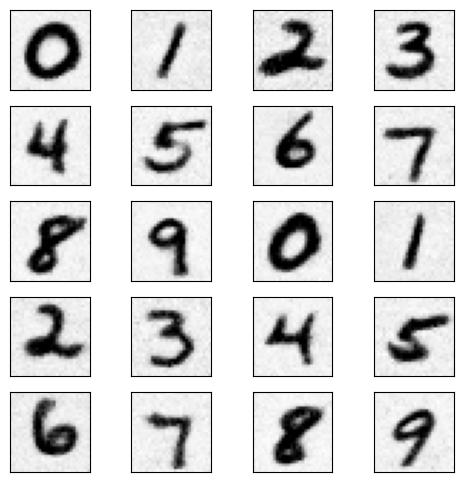

epoch 7


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 8


  0%|          | 0/195 [00:00<?, ?it/s]

Time schedule: [0.99999, 0.9444444444444444, 0.8888888888888888, 0.8333333333333334, 0.7777777777777778, 0.7222222222222222, 0.6666666666666666, 0.6111111111111112, 0.5555555555555556, 0.5, 0.4444444444444444, 0.3888888888888889, 0.3333333333333333, 0.2777777777777778, 0.2222222222222222, 0.16666666666666666, 0.1111111111111111, 0.05555555555555555, 0]


  0%|          | 0/18 [00:00<?, ?it/s]

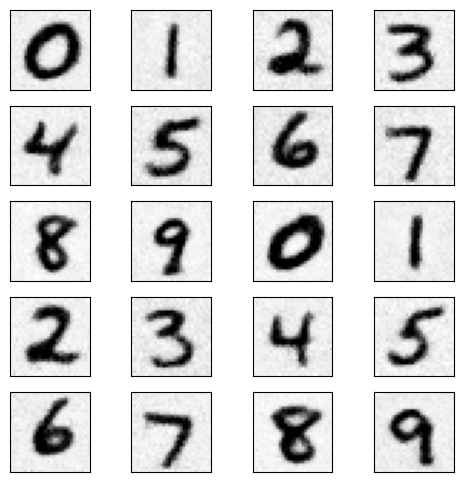

epoch 9


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 10


  0%|          | 0/195 [00:00<?, ?it/s]

Time schedule: [0.99999, 0.9444444444444444, 0.8888888888888888, 0.8333333333333334, 0.7777777777777778, 0.7222222222222222, 0.6666666666666666, 0.6111111111111112, 0.5555555555555556, 0.5, 0.4444444444444444, 0.3888888888888889, 0.3333333333333333, 0.2777777777777778, 0.2222222222222222, 0.16666666666666666, 0.1111111111111111, 0.05555555555555555, 0]


  0%|          | 0/18 [00:00<?, ?it/s]

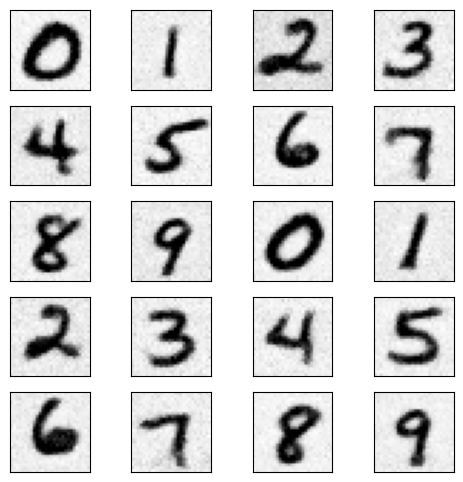

epoch 11


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 12


  0%|          | 0/195 [00:00<?, ?it/s]

Time schedule: [0.99999, 0.9444444444444444, 0.8888888888888888, 0.8333333333333334, 0.7777777777777778, 0.7222222222222222, 0.6666666666666666, 0.6111111111111112, 0.5555555555555556, 0.5, 0.4444444444444444, 0.3888888888888889, 0.3333333333333333, 0.2777777777777778, 0.2222222222222222, 0.16666666666666666, 0.1111111111111111, 0.05555555555555555, 0]


  0%|          | 0/18 [00:00<?, ?it/s]

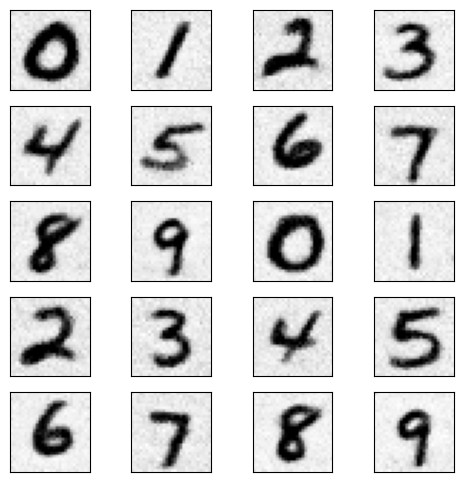

epoch 13


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 14


  0%|          | 0/195 [00:00<?, ?it/s]

Time schedule: [0.99999, 0.9444444444444444, 0.8888888888888888, 0.8333333333333334, 0.7777777777777778, 0.7222222222222222, 0.6666666666666666, 0.6111111111111112, 0.5555555555555556, 0.5, 0.4444444444444444, 0.3888888888888889, 0.3333333333333333, 0.2777777777777778, 0.2222222222222222, 0.16666666666666666, 0.1111111111111111, 0.05555555555555555, 0]


  0%|          | 0/18 [00:00<?, ?it/s]

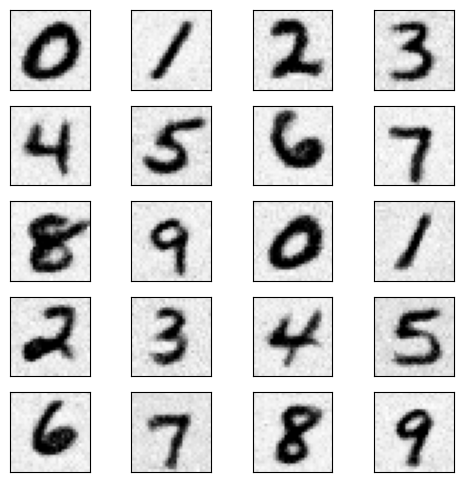

epoch 15


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 16


  0%|          | 0/195 [00:00<?, ?it/s]

Time schedule: [0.99999, 0.9444444444444444, 0.8888888888888888, 0.8333333333333334, 0.7777777777777778, 0.7222222222222222, 0.6666666666666666, 0.6111111111111112, 0.5555555555555556, 0.5, 0.4444444444444444, 0.3888888888888889, 0.3333333333333333, 0.2777777777777778, 0.2222222222222222, 0.16666666666666666, 0.1111111111111111, 0.05555555555555555, 0]


  0%|          | 0/18 [00:00<?, ?it/s]

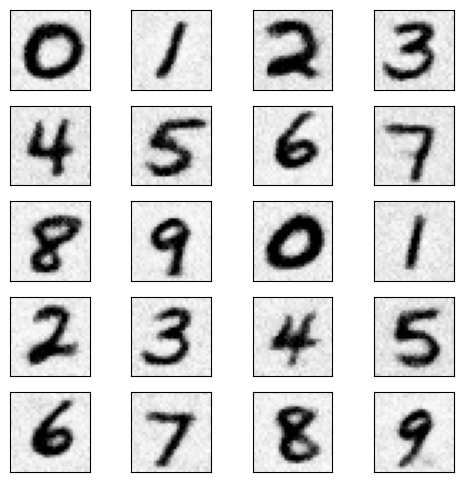

epoch 17


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 18


  0%|          | 0/195 [00:00<?, ?it/s]

Time schedule: [0.99999, 0.9444444444444444, 0.8888888888888888, 0.8333333333333334, 0.7777777777777778, 0.7222222222222222, 0.6666666666666666, 0.6111111111111112, 0.5555555555555556, 0.5, 0.4444444444444444, 0.3888888888888889, 0.3333333333333333, 0.2777777777777778, 0.2222222222222222, 0.16666666666666666, 0.1111111111111111, 0.05555555555555555, 0]


  0%|          | 0/18 [00:00<?, ?it/s]

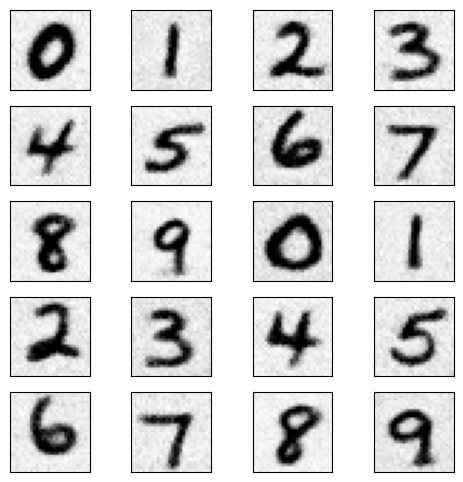

epoch 19


  0%|          | 0/195 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

In [17]:
n_epoch = 20
batch_size = 512
n_T = 400
n_feat = 128
lr = 1e-4
ws_test = [0.0, 0.5, 2.0]

unet = create_model().to(device)
unet.load_state_dict(torch.load("edm_model_checkpoint.pth"))
v_edm = EDMVel(model=unet)
v_edm.model.to(device)

optim = torch.optim.Adam(v_edm.parameters(), lr=lr)
# ref_end = 0.5 for left half, ref_end = 0 for full, ref_start = 0.5 + ref_end = 0 for right half
# train_reflow_loop(v_edm, optim, reflow_loader, lr, ws_test, n_epoch, batch_size, ref_end=0)
train_reflow_loop(
    v_edm, optim, reflow_loader, lr, ws_test, n_epoch, batch_size, ref_end=0.5
)

In [18]:
torch.save(v_edm.model.state_dict(), "left_rectified_edm_checkpoint.pth")

In [19]:
@torch.no_grad()
def v_edm_traj_sampler(
    v_edm,
    latents,
    class_labels=None,
    num_steps=18,
    guide_w=0.0,
    use_ema=True,
    cfg=True,
    drop_prob=0.0,
):
    time_schedule = [(i / num_steps) for i in reversed(range(1, num_steps + 1))] + [0]
    time_schedule[0] = 1 - 1e-5
    cnt = 0
    print(f"Time schedule: {time_schedule}")

    if class_labels is not None:
        class_labels = (
            nn.functional.one_hot(class_labels, num_classes=10)
            .type(torch.float32)
            .to(latents.device)
        )
        mask = torch.bernoulli(torch.ones_like(class_labels) * (1 - drop_prob))
        class_labels = class_labels * mask
        if cfg:
            class_labels = torch.cat([class_labels, torch.zeros_like(class_labels)])
    # Main sampling loop.
    x_next = latents.to(torch.float64).to(device) * time_schedule[0]

    rand_x = random.choice([10 + i for i in range(8)])
    rand_y = random.choice([10 + i for i in range(8)])

    random_trajs = [
        [x_next[i, 0, rand_x, rand_y].detach().cpu().item()]
        for i in range(latents.shape[0])
    ]
    middle = None
    for i in tqdm(range(len(time_schedule[:-1]))):
        t = (
            torch.ones((latents.shape[0] * (2 if cfg else 1),), device=device)
            * time_schedule[i]
        )
        t_next = (
            torch.ones((latents.shape[0] * (2 if cfg else 1),), device=x_next.device)
            * time_schedule[i + 1]
        )
        dt = t_next[0] - t[0]
        if cfg:
            x_hat = x_next.repeat(2, 1, 1, 1)
        else:
            x_hat = x_next

        vt = v_edm(x_hat, t, class_labels, use_ema=use_ema).to(torch.float64)
        x_next = x_hat + vt * dt

        # cfg guide
        if cfg:
            x_next_cond, x_next_uncond = x_next.chunk(2)
            x_next = (1 + guide_w) * x_next_cond - guide_w * x_next_uncond
        if i == (num_steps // 2):
            middle = x_next.clone().detach()

        for i in range(latents.shape[0]):
            random_trajs[i].append(x_next[i, 0, rand_x, rand_y].detach().cpu().item())

    return x_next, random_trajs

Time schedule: [0.99999, 0.9444444444444444, 0.8888888888888888, 0.8333333333333334, 0.7777777777777778, 0.7222222222222222, 0.6666666666666666, 0.6111111111111112, 0.5555555555555556, 0.5, 0.4444444444444444, 0.3888888888888889, 0.3333333333333333, 0.2777777777777778, 0.2222222222222222, 0.16666666666666666, 0.1111111111111111, 0.05555555555555555, 0]


  0%|          | 0/18 [00:00<?, ?it/s]

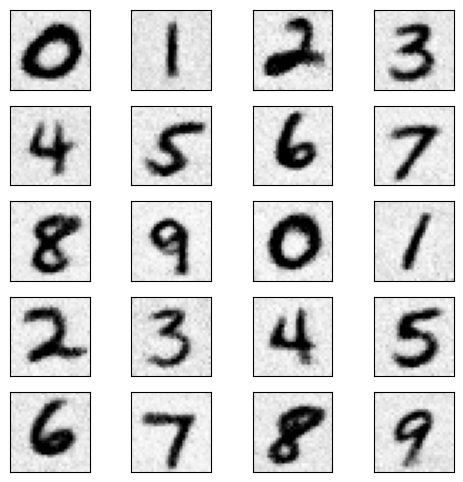

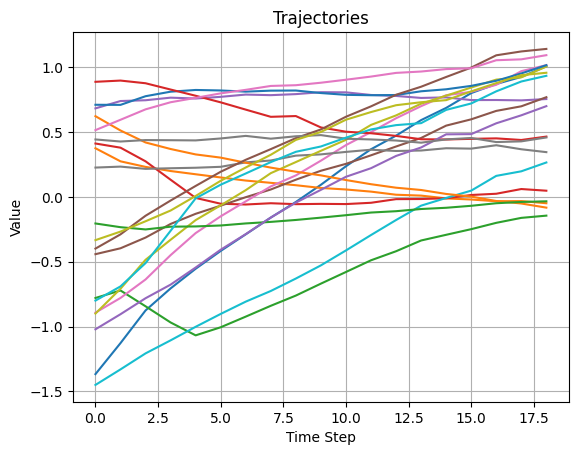

: 

In [ ]:
v_edm.model.eval()
with torch.no_grad():
    n_sample = 20
    x_T = torch.randn([n_sample, 1, 28, 28], device=device)
    c = torch.arange(0, 10).repeat(2).to(device)
    x_gen, trajs = v_edm_traj_sampler(
        v_edm, x_T, class_labels=c, num_steps=18, guide_w=4.5
    )

    x_gen = (x_gen / 2 + 0.5).clamp(0, 1)

    fig, ax = plt.subplots(5, 4, figsize=(6, 6))
    for i, j in itertools.product(range(5), range(4)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(n_sample):
        i = k // 4
        j = k % 4
        ax[i, j].cla()
        ax[i, j].imshow(x_gen[k, :].data.cpu().numpy().reshape(28, 28), cmap="Greys")
    plt.show()

    for i, traj in enumerate(trajs):
        plt.plot(traj, label=f"Trajectory {i+1}")

    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("Trajectories")
    # plt.legend()
    plt.grid(True)
    plt.show()